# Document Setup

- Project ID: EMB_ex16
- Researchers: DK
- Current Version: v1.0

See associated protocol for more details.

In [134]:
# Stdlib
import sys
import os
import random
from IPython.display import display, Latex
from datetime import datetime

# Scientific computing
import numpy as np
from scipy.sparse.linalg import eigsh

# Network science
import networkx as nx

# Data handling and vis
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.lines import Line2D

# Project source
sys.path.append("../../src/")
import synthetic
import utils

# Miscellaneous
from tqdm.auto import tqdm

In [135]:
proj_id = "EMB_ex16"
version = "v1.0"
researcher = "DK"
today = datetime.today().strftime("%Y%m%d")

filepath_dataframe = "../../results/dataframes/"
filepath_plots = "../../results/plots/"

# Experiment

## Preface

**Goal**

Explore fundamental differences in link prediction and multiplex reconstruction setting on uncorrelated Watts-Strogatz small-world ring topologies.

Unlike the similar EMB_ex14 and EMB_ex15, this experiment relies upon Laplacian Eigenmap embeddings.

**Procedure**

1. Generate a Watts-Strogatz small world ring, $G$, with parameter $\rho$.
2. Create a deepcopy of $G$, $H$, and shuffle the node labels of $H$.
3. Aggregate $G, H$; call it $A$
4. Observe some partial observations from $A$; call them $\theta_G, \theta_H$
5. Calculate the remnants; $R_G = A - \theta_H, R_H = A - \theta_G$
6. Embed $R_G, R_H$; call them $E_G, E_H$
7. Select some edge, $e = (i,j) \in A$
8. Calculate $d_G = d_{E_G}(i, j), d_H = d_{E_H}(i, j)$
9. Repeat (7), (8) for all edges $e \in A$
10. Examine resultant distribution of $d$

## Prerequisite code

In [136]:
def generate_small_world_duplex(number_of_nodes, neighborhood_size, rewiring_probability):
    """
    Generate a duplex of Watts-Strogatz small-world graphs with one layer having shuffled node labels of the other.
    """
    # Create one layyer, a Watts-Strogatz ring topology
    G = nx.watts_strogatz_graph(number_of_nodes, neighborhood_size, rewiring_probability)

    # Independent shallow copy the layer
    # * Note that node and edge attributes may have correlations - for this experiment, does not matter but it may in the future
    H = G.copy()
    # Shuffle H's nodes
    new_labels = list(H.nodes())
    random.shuffle(new_labels)  # ^ Why is there such a mix of in-place functions and not :,(
    relabeling_mapping = {node: new_labels[node] for node in range(H.number_of_nodes())}
    H = nx.relabel_nodes(H, relabeling_mapping)

    # ? Do I need to remove any still existing overlap? That would cause disconnectedness necessarily (if overlap is present)

    return G, H

In [137]:
def generate_ring_duplex(number_of_nodes):
    """
    Generate a duplex of rings with one layer having shuffled node labels of the other.
    """
    # Create one layer, a ring network
    G = nx.cycle_graph(number_of_nodes)

    # Independent shallow copy the layerrings
    # * Note that node and edge attributes may have correlations - for this experiment, does not matter but it may in the future
    H = G.copy()

    # Shuffle H's nodes
    new_labels = list(H.nodes())
    random.shuffle(new_labels)  # ^ Why is there such a mix of in-place functions and not :,(
    relabeling_mapping = {node: new_labels[node] for node in range(H.number_of_nodes())}
    H = nx.relabel_nodes(H, relabeling_mapping)

    # ? Do I need to remove any still existing overlap? That would cause disconnectedness necessarily (if overlap is present)

    return G, H

In [138]:
def get_representation(remnant, parameters):
    # Book-keeping
    ## Indexing objects
    _nodes = sorted(remnant.nodes())  # * Force networkx indexing
    _nodes_reindexing = {node: idx for idx, node in enumerate(_nodes)}  # Allow for non-contiguous node indices

    ## Hyperparams
    dimension = np.array(parameters["dimension"])
    maxiter = len(_nodes)*parameters["maxiter_multiplier"]
    if parameters["tol_exp"] >= 0:
        tol = 0
    else:
        tol = 10**parameters["tol_exp"]
    # Calculate normalized Laplacian
    L_normalized = nx.normalized_laplacian_matrix(remnant, nodelist=_nodes)

    # Account for first eigenvalue correlated with degrees
    dimension += 1
    # Account for algebraic multiplicity of trivial eigenvalues equal to number of connected components
    num_components = nx.number_connected_components(remnant)

    dimension += num_components
    # Calculate eigenspectra
    eigenvalues, eigenvectors = eigsh(
            L_normalized, k=dimension,
            which="SM", maxiter=maxiter, tol=tol,
        )

    # * Ensure algebraic multiplcity of trivial eigenvalue matches num_components
    # TODO: Fix calculation
    # for idx, w_ in enumerate(w):
    #     trivial_ = sum([np.isclose(val, 0) for val in w_])
    #     components_ = num_components[idx]
    #     if trivial_ != components_:
    #         raise ValueError(
    #             f"""Number of components and algebraic multiplicity
    #             of trivial eigenvalue do not match in remnant layer {idx}
    #             Found {components_} components, {trivial_} near-0 eigenvalues
    #             {w_}
    #             """
    #             )
    # Retrieve eigenvectors and first non-trivial dimension-many components
    eigenvectors = np.array([
            vector[-parameters["dimension"]:]
            for vector in eigenvectors
        ])

    indexed_eigenvectors = {node: eigenvectors[idx] for idx, node in enumerate(_nodes)}

    return indexed_eigenvectors

In [139]:
def calculate_distances(edge, E_G, E_H):
    # Retrieve nodes incident to edge
    i, j = edge

    # Calculate distance between incident nodes in both embeddings
    d_G = np.linalg.norm(E_G[i] - E_G[j])
    d_H = np.linalg.norm(E_H[i] - E_H[j])

    return d_G, d_H

## Workflow

In [140]:
# * Experiment Parameters
# >>> Network topology <<<
N = 100  # size of graphs
K = 2  # size of neighborhood of each node
rhos = np.linspace(0.1, 0.5, 11, endpoint=True) # rewiring probability

# >>> LE embedding <<<
params = {
    "dimension": 40,
    "maxiter_multiplier": 100,
    "tol_exp": -8
}

# >>> Other <<<
repeat = 100  # number of simulations

In [141]:
# * Steps (1), (2) - Get desired duplex
# G, H = generate_ring_duplex(N)

duplexes = {
    rho: generate_small_world_duplex(N, K, rho)
    for rho in rhos
}

### Multiple $\theta$

In [142]:
delta_theta = 0.02
theta_start = 0.02
theta_end = 0.98
thetas = np.arange(theta_start, theta_end + delta_theta, step=delta_theta)  # partial fraction of information

records_raw = []

In [143]:
for rho, (G, H) in tqdm(duplexes.items()):
    for theta in thetas:
        # * Steps (3) thru (5) - Observe a priori information and calculate remnants
        R_G, R_H, A = utils.partial_information(G, H, theta)

        # * Step (6) - Embed remnants
        E_G = get_representation(R_G, params)
        E_H = get_representation(R_H, params)

        # * Steps (7) thru (9) - Calculate distances of nodes incident to edges in both embeddings
        for edge in A.keys():
            d = calculate_distances(edge, E_G, E_H)

            record_raw = {
                "rho": rho,
                "theta": theta,
                "edge": edge,
                "d_G": d[0],
                "d_H": d[1],
                "ground_truth_aprx": 1 if ((edge[0] == edge[1]+1) or (edge[1] == edge[0]+1)) else 0,
                "classification": int(d[0] <= d[1]),
            }
            records_raw.append(record_raw)

100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


## Analysis

### Processing and cleanup

In [144]:
df = pd.DataFrame.from_records(records_raw)
df["correct"] = df["ground_truth_aprx"] == df["classification"]
df["inverse"] = (1/df["d_G"]) / ((1/df["d_G"]) + (1/df["d_H"]))
df["negexp"] = np.exp(-df["d_G"]) / (np.exp(-df["d_G"]) + np.exp(-df["d_H"]))

df_melted = pd.melt(df, id_vars=["rho", "theta", "edge", "inverse", "negexp", "correct", "ground_truth_aprx"], value_vars=["d_G", "d_H"], var_name="layer", value_name="distance")
df_melted = pd.melt(df_melted, id_vars=["rho", "theta", "edge", "correct", "layer", "distance", "ground_truth_aprx"], value_vars=["inverse", "negexp"], var_name="likelihood_metric", value_name="score")

In [145]:
df_ = pd.DataFrame(data = list(df.groupby(["rho", "theta"])["correct"].mean()), index = df.groupby(["rho", "theta"])["correct"].mean().index, columns = ['accuracy'])
df_ = df_.reset_index()

### Visualizations

<Figure size 1200x900 with 0 Axes>

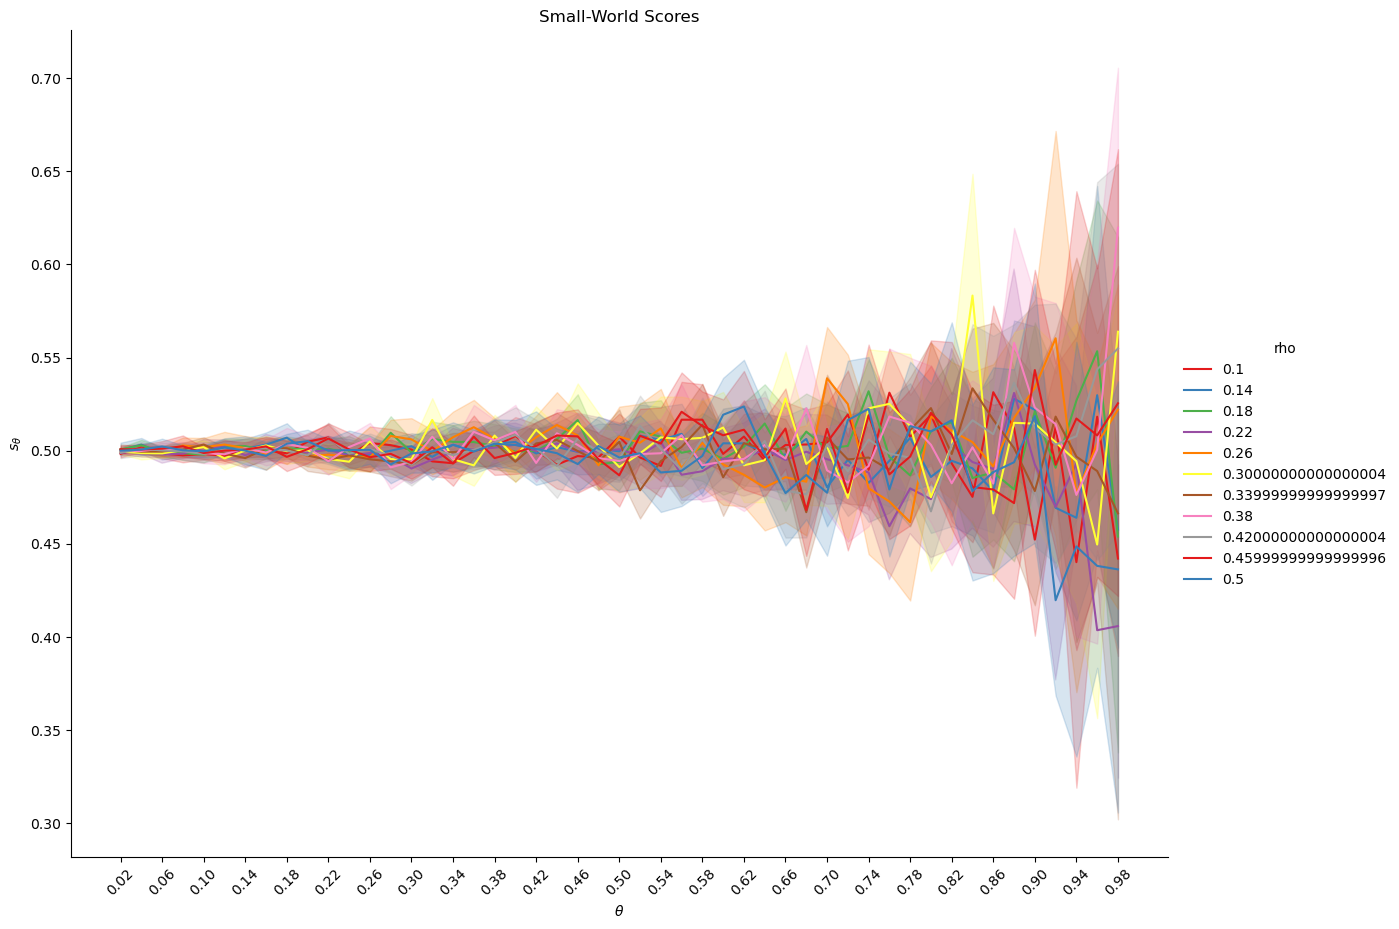

In [146]:
plt.figure(figsize=(12,9))

sns.relplot(
    data=df, kind="line",
    x="theta", y="inverse",
    hue="rho", palette="Set1",
    height=9, aspect=12/9
)

# plt.legend()

plt.xticks(thetas[::2], rotation=45)
# plt.yticks(np.arange(0.5, 1.05, 0.05))

plt.xlabel("$\\theta$")
plt.ylabel("$s_{\\theta}$")
plt.title("Small-World Scores")

plt.savefig(f"{filepath_plots}line_accuracy_{proj_id}{version}_{researcher}_{today}.png", facecolor="white", transparent=False)

<Figure size 1200x900 with 0 Axes>

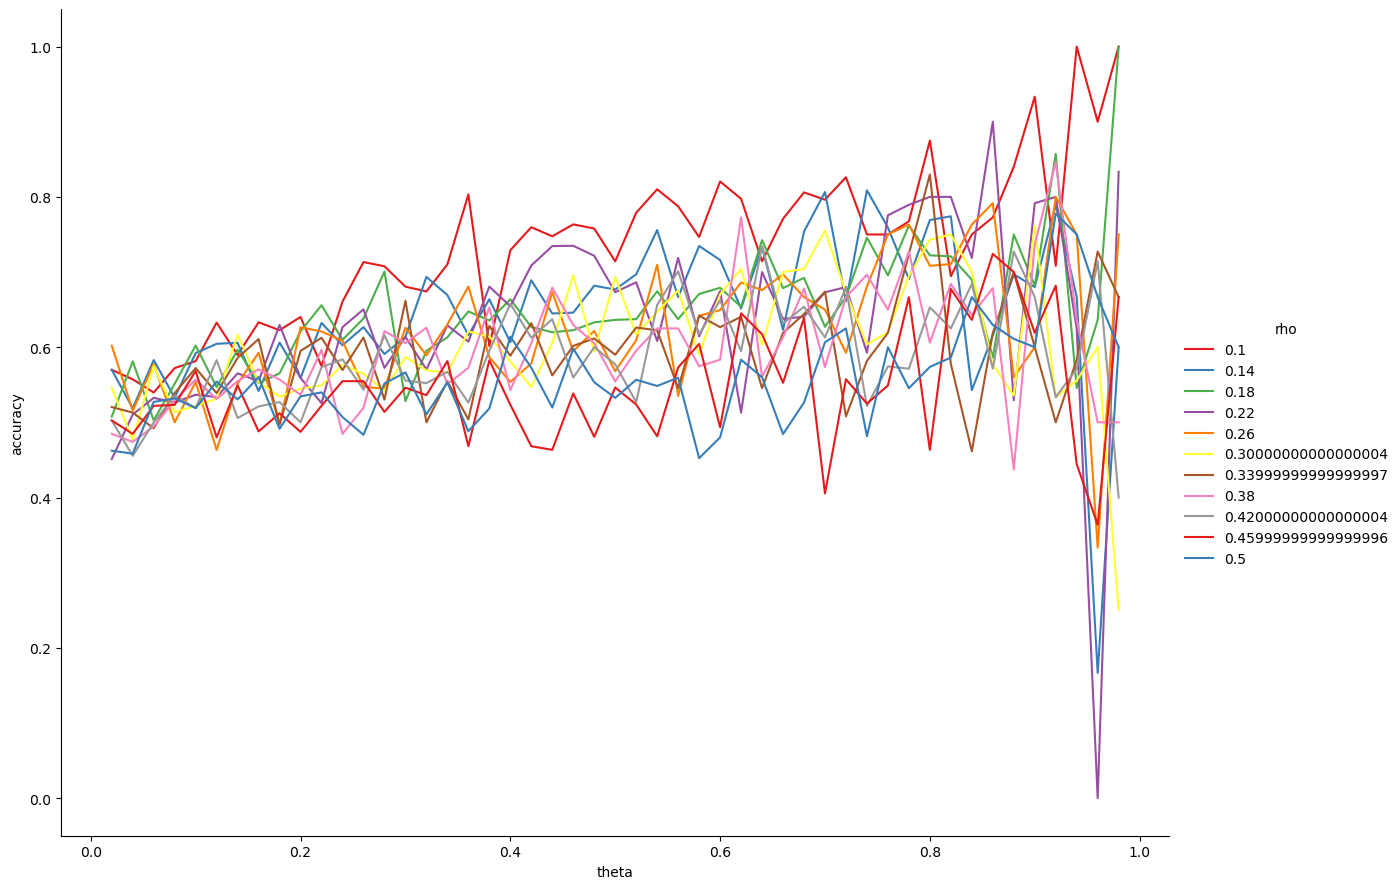

In [147]:
plt.figure(figsize=(12,9))

sns.relplot(
    data=df_, kind="line",
    x="theta", y="accuracy",
    hue="rho", palette="Set1",
    height=9, aspect=12/9
)

# plt.savefig(f"{filepath_plots}line_accuracy_{proj_id}{version}_{researcher}_{today}.png", facecolor="white", transparent=False)

Text(0.5, 1.0, 'Small World Reconstruction Accuracy (resolution: 8)')

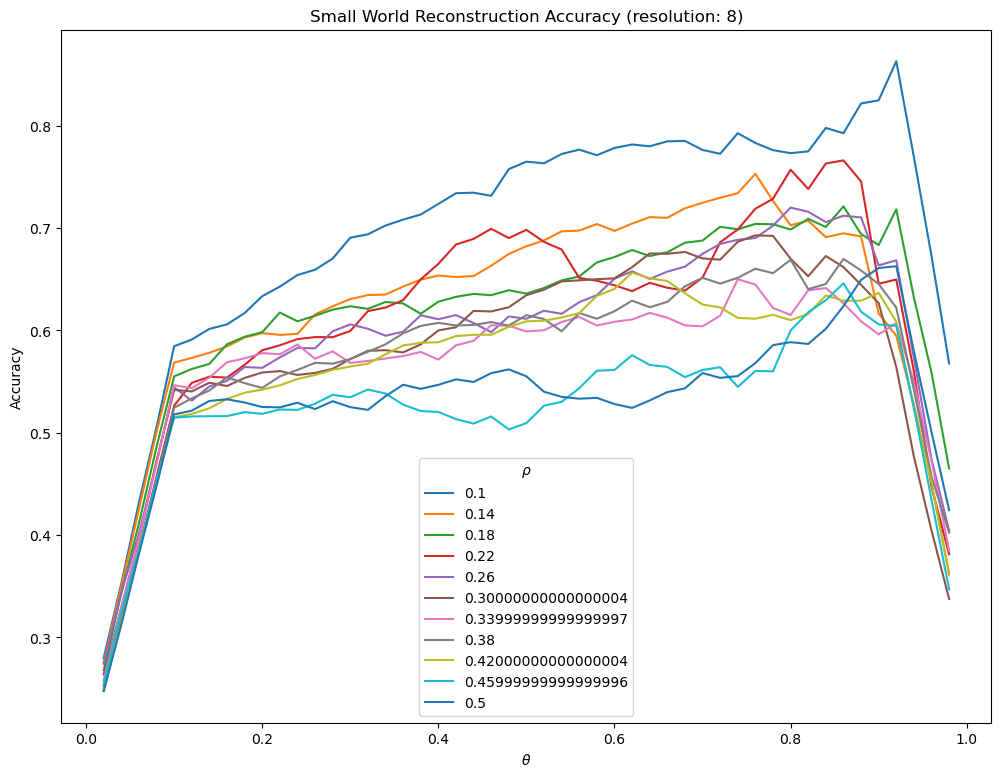

In [151]:
window_resolution = 8
window = [1/window_resolution] * window_resolution

plt.figure(figsize=(12,9))

for rho in rhos:
    plt.plot(thetas, np.convolve(window, df_.query("rho == @rho")["accuracy"], mode="same"), label=rho)

plt.legend(title="$\\rho$")

plt.xlabel("$\\theta$")
plt.ylabel("Accuracy")
plt.title(f"Small World Reconstruction Accuracy (resolution: {window_resolution})")